#🦕🦾 **FINE-TUNING GROUNDING DINO 🦾🦕**

##### *Grounding DINO model information and notebook explanation*

**Grounding DINO model information**
*   Transformer based object detection model [DETR model]
*   Open-Set object detection
*   Built by extending a closed-set detector DINO by performing vision-language modality fusion at multiple fases:
    *    Feature enhancer
    *    Langauage-guided query selection module
    *    Cross-modality decoder
*   Dual-encoder-single-decoder architecture

Loss functions:
*   BBOX:
    *   L1
    *   GIOU
*   Classification:
    *   Focal loss

Pre-training hyper paramters of the Grounding DINO (GD) paper:

*   optimizer AdamW
*   batch size 32
*   lr 1e-4
*   lr of image backbone 1e-5
*   lr of text backbone 1e-5
*   weight decay 0.0001
*   clip max norm 0.1
*   number of encoder layers 6
*   number of decoder layers 6
*   dim feedforward 2048
*   hidden dim 256
*   dropout 0.0
*   nheads 8
*   number of queries 900
*   set cost class 1.0
*   set cost bbox 5.0
*   set cost giou 2.0
*   ce loss coef 2.0
*   bbox loss coef 5.0
*   giou loss coef 2.0

**Notebook explanation**

This notebook can be used to fine-tune GD on a custom dataset. This happens in the following steps: load GD, load custom data, define the train and validation functions, load GD in a pytorch class, run the training and validation functions, save the new parameters to a .pth file, run a test on the test set of the dataset, run some manual tests.

### Imports and configuration

This block is used for all the imports of the notebook, connect with google drive for the data, set the random seed and check for GPUs.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive, files

drive.mount('/content/drive')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install supervision fastapi kaleido python-multipart uvicorn

import numpy as np
import os, cv2, bisect, random
import supervision as sv

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms
from torchvision.ops import box_convert
from torchvision.ops.boxes import _box_inter_union
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torchvision.ops import generalized_box_iou_loss
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image

import matplotlib.pyplot as plt

random_seed = 42
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

HOME = os.getcwd()
print(HOME)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typ

## **Grounding DINO Setup**

This block is used to download the Grounding DINO model and weights from Github. After the download necessary functions from GD are imported.

In [ ]:
if not os.path.exists('/content/GroundingDINO'):
    print('Downloading Grounding DINO...')

    %cd {HOME}
    !git clone https://github.com/IDEA-Research/GroundingDINO.git
    %cd {HOME}/GroundingDINO
    !pip install -q -e .
    !pip install -q roboflow

    CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
    print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

    %cd {HOME}
    !mkdir {HOME}/weights
    %cd {HOME}/weights

    !wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

    WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
    WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
    print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))
else:
    print('Grounding DINO is already installed')


%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
from groundingdino.util.utils import get_phrases_from_posmap

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 421 (delta 144), reused 126 (delta 126), pack-reused 232
Receiving objects: 100% (421/421), 12.85 MiB | 9.76 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━

## **Data Preprocessing and Loading**

This code block is used to load the custom dataset into a dictionary. It assumes that the dataset is already split in into train, validation and test sets. With the folowing directory setup:
* data directory
    * train
        * images
        * labels
    * valid
        * images
        * labels
    * test
        * images
        * labels

All the classes of the dataset should be in a single 'classes' list as strings (classes = ['dog', 'cat', ...]). All the labels files should have the folowing format:

class_integer_1 cx_1 cy_1 w_1 h_1

class_integer_2 cx_2 cy_2 w_2 h_2

An example:

89 0.23317307692307693 0.4951923076923077 0.4567307692307692 0.7668269230769231

55 0.7620192307692307 0.5024038461538461 0.4230769230769231 0.7427884615384616

With the first integer being the index of the class in the class list and the following 4 digits
the bounding box coordinates in cxcywh format for each class in the image.

The data is loaded into a dictionary with the keys being train, validation and test and the values of the keys are a list. Each item in the list refers to an image. Each item is a tuple consisting of the image as tensor (converted using the load_image function from GD), the class labels as integers and the bounding box coordinates in cxcywh format.

On line 10 the amount of batches loaded into the dictionary can be defined. Since it can cost a lot of RAM and training takes much longer for more batches it can be usefull to playaround with a smaller amount of batches.

In [ ]:
classes = ['acorn', 'axe', 'backpack', 'badger', 'bag', 'barrel', 'basket', 'bear', 'bed', 'bee', 'bell', 'bench', 'bird', 'birdcage', 'boar', 'boat', 'book', 'bottle', 'bow', 'bowl', 'box', 'bridge', 'broom', 'brush', 'bucket', 'building', 'butterfly', 'camel', 'campfire', 'candle', 'cane', 'cannon', 'car', 'cat', 'cello', 'chair', 'clock', 'couch', 'cow', 'cradle', 'crown', 'cup', 'curtain', 'deer', 'diningTable', 'dog', 'doghouse', 'donkey', 'door', 'dragon', 'drum', 'egg', 'elephant', 'ermine', 'feather', 'female', 'fence', 'fireplace', 'fish', 'fishingRod', 'flag', 'flower', 'flute', 'fox', 'frog', 'glasses', 'globe', 'goat', 'gun', 'hammer', 'hat', 'hedgehog', 'helmet', 'horse', 'hotAirBalloon', 'inkpot', 'insect', 'jackal', 'jar', 'jug', 'kettle', 'kite', 'knife', 'ladder', 'lamp', 'lifebuoy', 'lion', 'lizard', 'lobster', 'male', 'map', 'marmot', 'melon', 'monkey', 'moon', 'musicSheet', 'nest', 'net', 'painting', 'paintingStand', 'pan', 'pear', 'pen', 'penguin', 'piano', 'pickaxe', 'pig', 'pineapple', 'pipe', 'plant', 'plate', 'pot', 'pottedPlant', 'rabbit', 'rake', 'rat', 'rhino', 'sausage', 'saw', 'scale', 'scissors', 'scorpion', 'seal', 'shark', 'sheep', 'shield', 'shovel', 'sieve', 'skate', 'snail', 'snake', 'spear', 'spoon', 'sportsBall', 'squirrel', 'star', 'stool', 'stroller', 'suitcase', 'sun', 'sunflower', 'sword', 'teachingBoard', 'teapot', 'tent', 'tie', 'tiger', 'train', 'tree', 'trumpet', 'tub', 'turtle', 'umbrella', 'vase', 'violin', 'wagon', 'walnut', 'weight', 'whip', 'windmill', 'window', 'wineGlass', 'wolf', 'zebra']

# ------------------------------------------------------------------------------------
# Change data_directory and amount_of_batches

data_directory = '/content/drive/MyDrive/Delft/capstone data/1.0_Children_Books/'

amount_of_batches = 2

# ------------------------------------------------------------------------------------

datasets = ['train', 'valid', 'test']
data = {}
batch_size = 32

n = batch_size * amount_of_batches

for dataset in datasets:
    directory_images = data_directory+dataset+'/images'
    directory_labels = data_directory+dataset+'/labels'

    files_images = os.listdir(directory_images)
    files_labels = os.listdir(directory_labels)

    data[dataset] = []

    if dataset == 'valid':
        n = int(n/4)
        if n == 0:
            n = 1

    for idx, label in enumerate(files_labels[:n]):
        img_label = label[:-4]
        img = directory_images+'/'+img_label+'.jpg'
        _, img = load_image(img)

        f = open(directory_labels+'/'+label)
        f = [i.split(' ') for i in  f.read().split('\n')]
        f = [[float(j) for j in i] for i in f]

        y_labels_int = torch.LongTensor([i[0] for i in f])
        y_bboxes = torch.tensor([i[1:] for i in f])

        data[dataset].append((img, y_labels_int, y_bboxes))

random.shuffle(data['train'])
random.shuffle(data['valid'])
random.shuffle(data['test'])

## **Train, Validation and Test Functions**


This block contains all the necessary functions for training (fine-tuning) and validation. First the train helper functions are defined, which are used in the main train() and val() functions. Under the validation helper functions two functions are defined to help with evaluating the model. The functions are later explained in more detail.

### Train helper functions

Here all the following train helper functions are defined:
* process_data_loader_data
* calc_IoU
* FocalLoss
* phrases2classes
* perform_forward_pass
* link_predictions_to_true_labels
* calculate_loss
* calc_batch_acc
* preprocess_caption

Each function is described in more detail in its doctstring.

In [ ]:
L1_loss = nn.L1Loss()
crossentropy_loss = nn.CrossEntropyLoss()

def process_data(
    d: tuple[list[torch.tensor], list[torch.LongTensor], list[torch.tensor]],
    log: bool
) -> tuple[torch.tensor, torch.LongTensor, list, torch.tensor]:
    """
    Function to preprocess the data from the dataloader.
    Convert the true bboxes from cxcywh to xyxy.
    Create a labels string variant from the labels integers list.

    Args:
        - d: data (images as tensors, labels as integers, bboxes in cxcywh)
        - log: if the prints will be used

    Returns:
        - (images as tensors, labels as integers, labels as stings, bboxes in xyxy)
    """

    image_tensor, y_labels_int, y_bboxes_xywh = d

    y_bboxes_xyxy = box_convert(boxes=y_bboxes_xywh, in_fmt="cxcywh", out_fmt="xyxy")
    y_labels_str = [classes[i] for i in y_labels_int]

    image_tensor = image_tensor.to(device)

    if log:
        print('y_labels_str = {}'.format(y_labels_str))
        print('y_bboxes_xyxy = {}'.format(y_bboxes_xyxy))


    return (
        image_tensor,
        y_labels_int,
        y_labels_str,
        y_bboxes_xyxy
    )

def calc_IoU(boxA: torch.tensor, boxB: torch.tensor) -> float:
    """
    Function to calculate the IoU of two bounding boxes.

    Args:
        - bbox 1
        - bbox 2

    Returns:
        - IoU
    """

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        else:
            BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)

        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(focal_loss)
        else:
            return focal_loss

focal_loss = FocalLoss()

def phrases2classes(phrases: list, classes: list) -> list:
    """
    Functions to get the classes from the output phrases of GD.
    Example: 'female male' -> 'female'

    Args:
        - phrases: the output list of GD
        - classes: the true classes in the image

    Returns:
        - final list of found classes by GD
    """

    labels_str = []
    for phrase in phrases:
        for class_ in classes:
            if class_ in phrase:
                labels_str.append(class_)
                break

    return labels_str

def perform_forward_pass(
    net: nn.Module,
    image_tensor: torch.tensor,
    y_labels_str: list[str],
    log: bool
) -> tuple[list[str], torch.tensor, torch.tensor]:
    """
    Function to perform a forward pass and process the outputs of GD.
    Creates caption from y_labels_str.
    Converts the phrases outputs to classes.
    Converts the bbox from xywh to xyxy.

    Args:
        - net: the model to use
        - image_tensor: the image in tensor format
        - y_labels_str: the true string labels for a caption
        - log: if the prints will be used

    Returns:
        - y_hat_labels_str: the output labels of GD
        - y_hat_bboxes_xyxy: the output bboxes
        - y_hat_logits_raw: the logits for each prediction
    """

    caption = ". ".join(list(set(y_labels_str)))+'.'

    y_hat_bboxes_xywh, y_hat_logits, y_hat_phrases, y_hat_logits_raw = net(image_tensor, caption)
    y_hat_labels_str = phrases2classes(y_hat_phrases, y_labels_str)
    y_hat_bboxes_xyxy = box_convert(boxes=y_hat_bboxes_xywh, in_fmt="cxcywh", out_fmt="xyxy")

    if log:
        print('PROVIDED CAPTION: {}'.format(caption))
        print('y_hat_phrases = {}'.format(y_hat_phrases))
        print('y_hat_labels_str = {}'.format(y_hat_labels_str))
        # print('y_hat_bboxes_xywh = {}'.format(y_hat_bboxes_xywh))
        print('y_hat_bboxes_xyxy = {}'.format(y_hat_bboxes_xyxy))
        print('y_hat_logits = {}'.format(y_hat_logits))
        # print('y_hat_logits_raw = {}'.format(y_hat_logits_raw))

    return (
        y_hat_labels_str,
        y_hat_bboxes_xyxy,
        y_hat_logits,
        y_hat_logits_raw
    )

def link_predictions_to_true_labels(
    y_labels_int_v2: torch.tensor,
    y_labels_str_v2: list[str],
    y_bboxes_xyxy_v2: torch.tensor,
    y_hat_labels_str: list[str],
    y_hat_bboxes_xyxy: torch.tensor,
    y_hat_logits: torch.tensor,
    y_hat_logits_raw: torch.tensor,
    log: bool
) -> tuple[torch.tensor, list[str], torch.tensor, list[str], torch.tensor, torch.tensor, int]:
    """
    Function that links the GD outputs to the corresponding true labels.
    This is done by looping through all the true labels of an image and calculating the IoU
    for each output of GD. The highest IoU is then linked to the true label.

    The GD outputs that are linked to true labels are tracked so no GD outputs are
    linked multiple times.

    Args:
        - y values
        - y_hat values
        - log: if the prints will be used

    Returns:
        - y v2 values
        - y_hat v2 values
        - amount of classes that did not get linked to a true label
    """
    final_y_order_list = []
    final_y_hat_order_list = []

    old_len_y_v2_str = len(y_labels_str_v2)

    linked_GD_predictions = []

    for idx, true in enumerate(y_labels_str_v2):
        IoU_list = []
        new_y_order_list = []
        new_y_hat_order_list = []

        for idx2, pred in enumerate(y_hat_labels_str):
            IoU = calc_IoU(y_bboxes_xyxy_v2[idx], y_hat_bboxes_xyxy[idx2])

            if idx2 not in linked_GD_predictions:
                IoU_list.append(IoU)
                new_y_order_list.append(idx)
                new_y_hat_order_list.append(idx2)


        if IoU_list != []:
            IoU_list = np.array([i.item() for i in IoU_list])

            argmax = np.argmax(IoU_list)

            new_y_order = new_y_order_list[argmax]
            final_y_order_list.append(new_y_order)

            new_y_hat_order = new_y_hat_order_list[argmax]
            final_y_hat_order_list.append(new_y_hat_order)
            linked_GD_predictions.append(new_y_hat_order_list[argmax])

    if final_y_order_list != []:
        y_labels_int_v2 = torch.tensor([y_labels_int_v2[i] for i in final_y_order_list]).to(device)
        y_labels_str_v2 = [y_labels_str_v2[i] for i in final_y_order_list]
        y_bboxes_xyxy_v2 = y_bboxes_xyxy_v2.clone().index_select(0, torch.tensor(final_y_order_list)).to(device)
    else:
        y_labels_int_v2 = torch.tensor([])
        y_labels_str_v2 = []
        y_bboxes_xyxy_v2 = torch.tensor([])

    if final_y_hat_order_list != []:
        y_hat_labels_str_v2 = [y_hat_labels_str[i] for i in final_y_hat_order_list]
        y_hat_bboxes_xyxy_v2 = y_hat_bboxes_xyxy.clone().index_select(0, torch.tensor(final_y_hat_order_list).to(device)).to(device)
        y_hat_logits_v2 = y_hat_logits.clone().index_select(0, torch.tensor(final_y_hat_order_list).to(device)).to(device)
        y_hat_logits_raw_v2 = y_hat_logits_raw.clone().index_select(0, torch.tensor(final_y_hat_order_list).to(device)).to(device)
    else:
        y_hat_labels_str_v2 = []
        y_hat_bboxes_xyxy_v2 = torch.tensor([])
        y_hat_logits_v2 = torch.tensor([])
        y_hat_logits_raw_v2 = torch.tensor([])

    count_not_found = old_len_y_v2_str - len(y_labels_str_v2)

    if log:
        # print('final_y_order_list = {}'.format(final_y_order_list))
        # print('final_y_hat_order_list = {}'.format(final_y_hat_order_list))

        print('[V2 VALUES]')
        print('y_labels_str_v2 = {}'.format(y_labels_str_v2))
        print('y_labels_int_v2 = {}'.format(y_labels_int_v2))
        print('y_bboxes_xyxy_v2 = {}'.format(y_bboxes_xyxy_v2))

        print('y_hat_labels_str_v2 = {}'.format(y_hat_labels_str_v2))
        print('y_hat_bboxes_xyxy_v2 = {}'.format(y_hat_bboxes_xyxy_v2))
        print('y_hat_logits_v2 = {}'.format(y_hat_logits_v2))
        # print('y_hat_logits_raw_v2 = {}'.format(y_hat_logits_raw_v2))

    return (
        y_labels_int_v2,
        y_labels_str_v2,
        y_bboxes_xyxy_v2,
        y_hat_labels_str_v2,
        y_hat_bboxes_xyxy_v2,
        y_hat_logits_v2,
        y_hat_logits_raw_v2,
        count_not_found
    )

def calculate_loss(
    y_bboxes_xyxy_v2: torch.tensor,
    y_labels_int_v2: torch.tensor,
    y_hat_bboxes_xyxy_v2: torch.tensor,
    y_hat_logits_v2: torch.tensor,
    y_hat_logits_raw_v2: torch.tensor,
    bbox_loss_coef: float,
    GIoU_loss_coef: float,
    focal_loss_coef: float,
    log: bool,
) -> torch.tensor:
    """
    Function to calculate the loss. For the bboxes it uses the L1 and the GIoU loss. For classification it uses the focal loss,
    the targets are a 1D tensor that are the true class labels as integers and the inputs are the raw logits outputs for each class by GD.

    The losses are individually multiplied by loss coefficients and then summed

    Args:
        - y v2 values
        - y_hat v2 values
        - loss coefficients

    Returns:
        - Loss
    """
    loss_box_L1 = L1_loss(y_hat_bboxes_xyxy_v2, y_bboxes_xyxy_v2)
    loss_box_GIoU = generalized_box_iou_loss(y_hat_bboxes_xyxy_v2, y_bboxes_xyxy_v2, reduction='mean')
    loss_box = (bbox_loss_coef*loss_box_L1 + GIoU_loss_coef*loss_box_GIoU)

    loss_cls = focal_loss_coef*focal_loss(y_hat_logits_raw_v2, y_labels_int_v2)

    loss = loss_box + loss_cls

    if log:
        print('loss_box_L1 = {}'.format(loss_box_L1))
        print('loss_box_GIoU = {}'.format(loss_box_GIoU))
        print('loss_box = {}'.format(loss_box))
        print('loss_cls = {}'.format(loss_cls))
        print('loss = {}\n'.format(loss))

    return loss

def calc_batch_acc(y_labels_str_v2: list[str], y_hat_labels_str_v2: list[str]) -> float:
    """
    Function to calculate the classification accuracy of the found matching bounding boxes.

    Args:
        - y string labels
        - y_hat string labels

    Returns:
        - accuracy
    """

    if not y_labels_str_v2:
        return 0

    correct_count = sum(1 for i, j in zip(y_labels_str_v2, y_hat_labels_str_v2) if i == j)

    return correct_count / len(y_labels_str_v2)

def preprocess_caption(caption: str) -> str:
    """
    Function from groundingDINO that preprocesses the input prompt. It does so by stripping the prompt and adding a "." if necessary.

    Args:
        - caption: the input prompt to groundingDINO

    Returns:
        - preprocessed prompt
    """
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

### Train function

Here the main train function is defined. These are the steps it takes:

1. Loop through the train list in batch chunks
2. Loop through each batch
3. Process the batch element with process_data()
4. Perform a forward pass with the custom GD model
5. Link all the outputs of GD with the true labels based on the IoU of the boudning boxes with link_predictions_to_true_labels()
6. Calculate the percentage of not gound objects by GD
7. Calculate classifying accuracy of the found objects
8. Calculate the bounding box MSE
9. Track the not ound percentage, accuracy and MSE
10. Calculate the loss with calculate_loss()
11. Perform the weight update after loss.backward() is performed for each element in the batch
12. Return the mean of the not found percentage, accuracy and MSE of all the batches

Note that it is not possible to perform parallized computations on batches by creating an extra dimension in the input tensors. For example the images having shape (M, 3, H, W) with M the batch size. This is not possible for several reasons, the main one being that the input bounding box tensors vary in size, since images can have different amounts of classes, this would result in 'ragged' tensors.

To train the model in batches loss.backward() is called for every element in the batch and after each batch optimizer.step() is called. This way all the gradient



In [ ]:
def train(
    train_data: list,
    net: nn.Module,
    optimizer: optim.Adam,
    log: bool,
    bbox_loss_coef: float=5,
    GIoU_loss_coef: float=2,
    focal_loss_coef: float=2
) -> tuple[list]:

    epoch_loss_list = []
    epoch_acc_list = []
    epoch_cls_not_found_per_list = []
    epoch_bbox_MSE_list = []

    for idx in range(0, len(train_data), batch_size):
        batch = train_data[idx:idx+batch_size]

        optimizer.zero_grad()

        batch_loss_list = []
        batch_acc_list = []
        batch_cls_not_found_per_list = []
        batch_bbox_MSE_list = []

        for idx2, batch_element in enumerate(batch):
            batch_count_cls_not_found = 0

            image_tensor, y_labels_int, y_labels_str, y_bboxes_xyxy = process_data(batch_element, log)
            y_hat_labels_str, y_hat_bboxes_xyxy, y_hat_logits, y_hat_logits_raw = perform_forward_pass(net, image_tensor, y_labels_str, log)

            batch_true_cls_count = len(y_labels_str)

            if y_hat_labels_str == []:
                continue

            y_labels_int_v2, y_labels_str_v2, y_bboxes_xyxy_v2, y_hat_labels_str_v2, y_hat_bboxes_xyxy_v2, y_hat_logits_v2, y_hat_logits_raw_v2, count_not_found = link_predictions_to_true_labels(
                y_labels_int,
                y_labels_str,
                y_bboxes_xyxy,
                y_hat_labels_str,
                y_hat_bboxes_xyxy,
                y_hat_logits,
                y_hat_logits_raw,
                log
            )

            batch_count_cls_not_found += count_not_found

            if batch_true_cls_count != 0:
                batch_cls_not_found_per_list.append(batch_count_cls_not_found/batch_true_cls_count)

            batch_acc_list.append(calc_batch_acc(y_labels_str_v2, y_hat_labels_str_v2))
            bbox_MSE = torch.mean((y_bboxes_xyxy_v2-y_hat_bboxes_xyxy_v2)**2)
            if not torch.isnan(bbox_MSE):
                batch_bbox_MSE_list.append(bbox_MSE.cpu().item())

            if y_hat_labels_str_v2 == []:
                continue

            loss = calculate_loss(
                y_bboxes_xyxy_v2,
                y_labels_int_v2,
                y_hat_bboxes_xyxy_v2,
                y_hat_logits_v2,
                y_hat_logits_raw_v2,
                bbox_loss_coef,
                GIoU_loss_coef,
                focal_loss_coef,
                log
            )

            if not torch.isnan(loss):
                loss.backward()

                batch_loss_list.append(loss.cpu().detach())

                # if log:
                #     print('MODEL PARAMETER GRADIENT CHECK: {}'.format(list(model.parameters())[-1].grad))


        epoch_loss_list.append(np.mean(batch_loss_list))
        epoch_acc_list.append(np.mean(batch_acc_list))
        epoch_cls_not_found_per_list.append(np.mean(batch_cls_not_found_per_list))
        epoch_bbox_MSE_list.append(np.mean(batch_bbox_MSE_list))


        optimizer.step()
        # print("\rBATCH {} IN LOADER | LOSS: {}".format(int(idx/batch_size)+1, loss.item()), end="")


    return (
        np.mean(epoch_loss_list),
        np.mean(epoch_acc_list),
        np.mean(epoch_cls_not_found_per_list),
        np.mean(epoch_bbox_MSE_list)
    )

### Validation helper functions

In this block the validation helper functions are defined. They consist of a sample_image_check(), which takes in a model, image path and text prompt and then performs a forward pass with the model and then returns the predictions of the model visualized in an image. And the second function is create_training_curves(), which takes in lists for all the mentioned metrics in the train() function for all the trained epochs and plots the curves of the metrics against the amount of epochs.

In [ ]:
def sample_image_check(image: torch.tensor, image_source: torch.tensor, model: nn.Module = None, prompt: str = '', predict_bool: bool = True, input_data: None | tuple = None) -> None:
    """
    Function that runs a single sample through a model or shows the true labels.
    This is used to compare the model before and after training.

    To show the true labels set predict_bool to False and provide the
    bounding boxes, logits and phrases in the input_data parameter as a tuple.

    To predict using a model provide a model and prompt.

    In both cases the image in tensor format and image_source should be provided.
    These are the outputs of the load_image function of GD.
    """

    if predict_bool:
        boxes, logits, phrases, _ = model(image.to(device), prompt)
        annotated_frame = annotate(image_source=image_source, boxes=boxes.detach().cpu(), logits=logits.detach().cpu(), phrases=phrases)
    elif not input_data is None:
        boxes, logits, phrases = input_data
        annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    else:
        print('Provide data or set predict to True')
        return None

    %matplotlib inline
    sv.plot_image(annotated_frame, (6, 6))

def create_training_curves(
    train_loss: list,
    train_acc: list,
    train_cls_not_found:list,
    train_bbox_MSE:list,
    val_loss: list,
    val_acc: list,
    val_cls_not_found:list,
    val_bbox_MSE:list
) -> None:
    """
    Functions to create training curves. Considering the loss, classifying accuracy, percentage of the clases that are not found by GD
    and bounding box MSE. All data is plotted against the amount of epochs.

    The functions itself returns None but show the plots.

    Args:
        - train data
        - validation data
    """
    plt.figure()
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_cls_not_found, label='train')
    plt.plot(val_cls_not_found, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Classes not found')
    plt.title('Classes not found by GD')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_bbox_MSE, label='train')
    plt.plot(val_bbox_MSE, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('BBOX MSE')
    plt.legend()
    plt.show()


### Validation function

The validation functions does the same as the main train function but with torch.no_grad() and it does not calculate the gradients and does not perform an optimizer step.

In [ ]:
def val(
    val_data: list,
    net: nn.Module,
    optimizer: optim.Adam,
    log: bool,
    bbox_loss_coef: float=5,
    GIoU_loss_coef: float=2,
    focal_loss_coef: float=2
) -> tuple[list]:

    epoch_loss_list = []
    epoch_acc_list = []
    epoch_cls_not_found_per_list = []
    epoch_bbox_MSE_list = []

    with torch.no_grad():
        for idx in range(0, len(val_data), batch_size):
            batch = val_data[idx:idx+batch_size]

            batch_loss_list = []
            batch_acc_list = []
            batch_cls_not_found_per_list = []
            batch_bbox_MSE_list = []

            for idx2, batch_element in enumerate(batch):
                batch_count_cls_not_found = 0

                image_tensor, y_labels_int, y_labels_str, y_bboxes_xyxy = process_data(batch_element, log)
                y_hat_labels_str, y_hat_bboxes_xyxy, y_hat_logits, y_hat_logits_raw = perform_forward_pass(net, image_tensor, y_labels_str, log)

                batch_true_cls_count = len(y_labels_str)

                if y_hat_labels_str == []:
                    continue


                y_labels_int_v2, y_labels_str_v2, y_bboxes_xyxy_v2, y_hat_labels_str_v2, y_hat_bboxes_xyxy_v2, y_hat_logits_v2, y_hat_logits_raw_v2, count_not_found = link_predictions_to_true_labels(
                    y_labels_int,
                    y_labels_str,
                    y_bboxes_xyxy,
                    y_hat_labels_str,
                    y_hat_bboxes_xyxy,
                    y_hat_logits,
                    y_hat_logits_raw,
                    log
                )

                batch_count_cls_not_found += count_not_found

                batch_cls_not_found_per_list.append(batch_count_cls_not_found/batch_true_cls_count if batch_true_cls_count != 0 else 0)
                batch_acc_list.append(calc_batch_acc(y_labels_str_v2, y_hat_labels_str_v2))
                bbox_MSE = torch.mean((y_bboxes_xyxy_v2-y_hat_bboxes_xyxy_v2)**2)
                if not torch.isnan(bbox_MSE):
                    batch_bbox_MSE_list.append(bbox_MSE.cpu().item())

                if y_hat_labels_str_v2 == []:
                    continue

                loss = calculate_loss(
                    y_bboxes_xyxy_v2,
                    y_labels_int_v2,
                    y_hat_bboxes_xyxy_v2,
                    y_hat_logits_v2,
                    y_hat_logits_raw_v2,
                    bbox_loss_coef,
                    GIoU_loss_coef,
                    focal_loss_coef,
                    log
                )

                if not torch.isnan(loss):
                    batch_loss_list.append(loss.cpu().detach())


            epoch_loss_list.append(np.mean(batch_loss_list))
            epoch_acc_list.append(np.mean(batch_acc_list))
            epoch_cls_not_found_per_list.append(np.mean(batch_cls_not_found_per_list))
            epoch_bbox_MSE_list.append(np.mean(batch_bbox_MSE_list))

    return (
        np.mean(epoch_loss_list),
        np.mean(epoch_acc_list),
        np.mean(epoch_cls_not_found_per_list),
        np.mean(epoch_bbox_MSE_list)
    )

## **Grounding DINO Implementation**

In this block the Grounding DINO model is loaded into a PyTorch class to be able to modidfy the outputs of the network. Then the run fuction is defined and lastly the code for fine-tuning the model (with (un)freezing layers) and exporting the new parameters.

### Custom model - Grounding DINO V2

This code blocks loads the Grounding DINO model into a PyTorch class. The basemodel_forward() functions consists mainly of code from the GD Github, it is modified slightly to also outut the raw logits of the network without an extra filter being applied.

In [ ]:
class GroundingDINOV2(nn.Module):
    def __init__(self, box_threshold=0.35, text_threshold=0.25, WEIGHTS_PATH):
        super(GroundingDINOV2, self).__init__()

        self.box_threshold = box_threshold
        self.text_threshold = text_threshold

        self.basemodel = load_model(CONFIG_PATH, WEIGHTS_PATH)

    def basemodel_forward(self, image, caption, remove_combined=False):
        """
        This function is mainly from the GD Github and slightly modified to also output
        the prediction_logits without the mask .max(dim=1)[0] being applied.

        Args:
            - image: an image in tensor format
            - caption: classes in a string with each class ending with a '.'
                Example 'dog.' or 'cat. dog. bird.'

        Returns:
            - bboxes: bounding boxes in cxcywh
            - logits: probability of each class
            - phrases: the found classes
                'phrases' format is different from the 'labels' format since phrases sometimes contain
                a combination of classes.
                    Example: ['female male', 'dog', 'cat']
                    'female male' being the combination
            - logits_raw: the entire logits tensor for a class used for the classifying loss
        """
        caption = preprocess_caption(caption)
        outputs = self.basemodel(image[None], captions=[caption])

        prediction_logits = outputs["pred_logits"].sigmoid()[0]  # prediction_logits.shape = (nq, 256)
        prediction_logits_no_sigmoid = outputs["pred_logits"][0]  # prediction_logits.shape = (nq, 256)
        prediction_boxes = outputs["pred_boxes"][0]  # prediction_boxes.shape = (nq, 4)

        mask = prediction_logits.max(dim=1)[0] > self.box_threshold
        logits = prediction_logits[mask]  # logits.shape = (n, 256)
        boxes = prediction_boxes[mask]  # boxes.shape = (n, 4)

        logits_raw = prediction_logits[mask]

        tokenizer = self.basemodel.tokenizer
        tokenized = tokenizer(caption)

        if remove_combined:
            sep_idx = [i for i in range(len(tokenized['input_ids'])) if tokenized['input_ids'][i] in [101, 102, 1012]]

            phrases = []
            for logit in logits:
                max_idx = logit.argmax()
                insert_idx = bisect.bisect_left(sep_idx, max_idx)
                right_idx = sep_idx[insert_idx]
                left_idx = sep_idx[insert_idx - 1]
                phrases.append(get_phrases_from_posmap(logit > self.text_threshold, tokenized, tokenizer, left_idx, right_idx).replace('.', ''))
        else:
            phrases = [
                get_phrases_from_posmap(logit > self.text_threshold, tokenized, tokenizer).replace('.', '')
                for logit
                in logits
            ]

        return boxes, logits.max(dim=1)[0], phrases, logits_raw

    def forward(self, image, caption):
        """
        The forward function of the module. Also used met model(image, caption) is called.
        The forward functoin sends the inputs to self.basemodel_forward and returns self.basemodel_forward's outpus

        See self.basemodel_forward for a detailed arguments and returns explanation.
        """
        return self.basemodel_forward(image, caption)

### Run Grounding DINO V2

This block contains the run() function and code to fine-tune GD.

#### Run function

This function initializes the optimizer, creates all the lists for the training curves and runs the train() and val() functions for each epoch. The function also listens for a keyboard interrupt or other error, if this happens all the training curve data is returned.

In [ ]:
def run(model, epochs, lr, lbda=0.0001, log=False):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lbda)

    epoch_count = 0

    train_loss, train_acc, train_cls_not_found, train_bbox_MSE = [], [], [], []
    val_loss, val_acc, val_cls_not_found, val_bbox_MSE = [], [], [], []

    print('\n[STARTING EPOCH LOOP]')
    print('Learning rate: {}'.format(lr))
    print('Amount of epochs: {}\n'.format(epochs))

    try:
        for epoch in range(epochs):
            model.train()
            epoch_loss_train, epoch_acc_train, epoch_cls_not_fount_train, epoch_bbox_MSE_train = train(data['train'], model, optimizer, log)

            model.eval()
            epoch_loss_val, epoch_acc_val, epoch_cls_not_fount_val, epoch_bbox_MSE_val = val(data['valid'], model, optimizer, False)

            train_loss.append(epoch_loss_train)
            train_acc.append(epoch_acc_train)
            train_cls_not_found.append(epoch_cls_not_fount_train)
            train_bbox_MSE.append(epoch_bbox_MSE_train)

            val_loss.append(epoch_loss_val)
            val_acc.append(epoch_acc_val)
            val_cls_not_found.append(epoch_cls_not_fount_val)
            val_bbox_MSE.append(epoch_bbox_MSE_val)

            epoch_count += 1

            print("\rEPOCH: {} | TRAIN LOSS: {} | VAL LOSS: {}".format(epoch+1, epoch_loss_train, epoch_loss_val), end="")
    except KeyboardInterrupt:
        pass
    except Exception as e:
        print(e)
    finally:
        return (
            train_loss,
            train_acc,
            train_cls_not_found,
            train_bbox_MSE,
            val_loss,
            val_acc,
            val_cls_not_found,
            val_bbox_MSE
        )

#### Run model

This block contains the code to fine-tune the model. First all the gradients of the parameters are disabled. Then only for specific layers gradients are instantiated. This is done by modifying the requires_grad parameter of a model parameter. After unfeezing certain layers the model is run for a chosen amount of epochs and learning rate. When the training is done the training curves are plotted and all the parameters are compared with the initial parameters to check if the parameters have really been changed.

The measure the performance of the fine-tuned model the classifying accuracy, bounding box MSE and percentage of classes not found are used.

Under 'FREEZE AND UNFREEZE LAYERS' the code can be modified to choose which layers should be updated.

To show the model structure 'print(model)' can be used. To get specific layer names the following code can be used.:

for idx, (name, param) in enumerate(model.named_parameters()):
    param.requires_grad = True

Under 'FINE-TUNE MODEL' the amount of epochs and learning rate can be set.

final text_encoder_type: bert-base-uncased
[FREEZE AND UNFREEZE LAYERS]
basemodel.transformer.decoder.layers.0.linear1.weight - Grad: True
basemodel.transformer.decoder.layers.0.linear1.bias - Grad: True
basemodel.transformer.decoder.layers.0.linear2.weight - Grad: True
basemodel.transformer.decoder.layers.0.linear2.bias - Grad: True
basemodel.transformer.decoder.layers.1.linear1.weight - Grad: True
basemodel.transformer.decoder.layers.1.linear1.bias - Grad: True
basemodel.transformer.decoder.layers.1.linear2.weight - Grad: True
basemodel.transformer.decoder.layers.1.linear2.bias - Grad: True
basemodel.transformer.decoder.layers.2.linear1.weight - Grad: True
basemodel.transformer.decoder.layers.2.linear1.bias - Grad: True
basemodel.transformer.decoder.layers.2.linear2.weight - Grad: True
basemodel.transformer.decoder.layers.2.linear2.bias - Grad: True
basemodel.transformer.decoder.layers.3.linear1.weight - Grad: True
basemodel.transformer.decoder.layers.3.linear1.bias - Grad: True
base

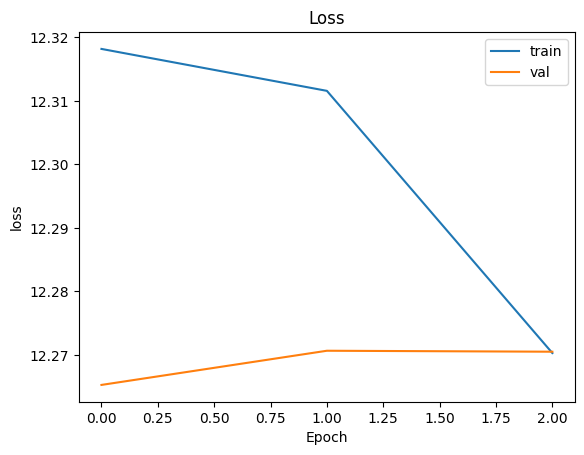

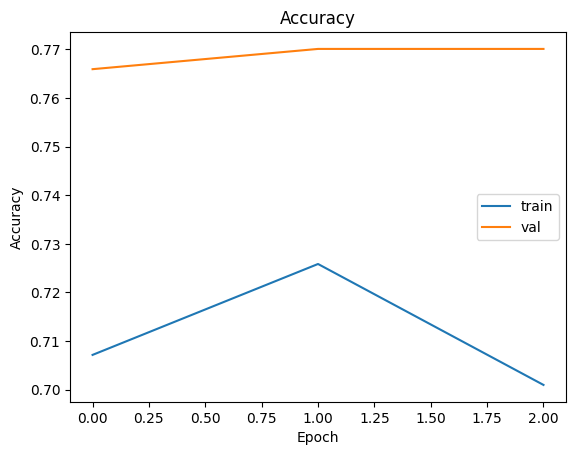

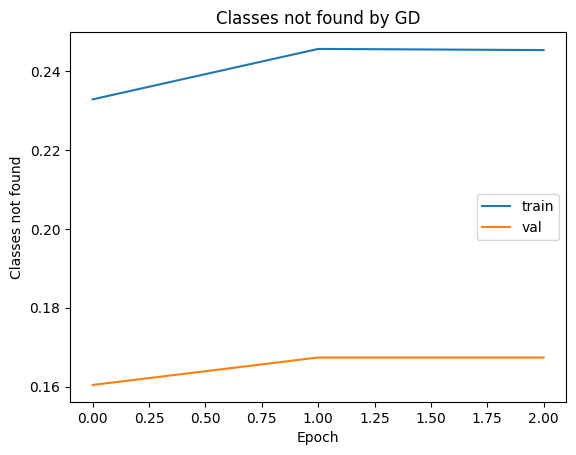

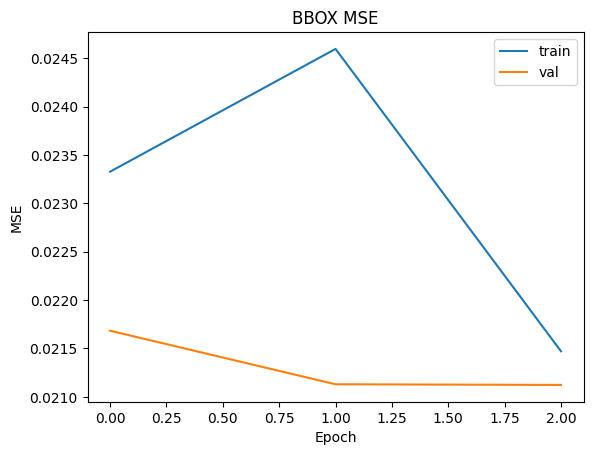


[COMPARING PARAMETERS]
basemodel.transformer.decoder.layers.0.linear1.weight | Update = True
basemodel.transformer.decoder.layers.0.linear1.bias | Update = True
basemodel.transformer.decoder.layers.0.linear2.weight | Update = True
basemodel.transformer.decoder.layers.0.linear2.bias | Update = True
basemodel.transformer.decoder.layers.1.linear1.weight | Update = True
basemodel.transformer.decoder.layers.1.linear1.bias | Update = True
basemodel.transformer.decoder.layers.1.linear2.weight | Update = True
basemodel.transformer.decoder.layers.1.linear2.bias | Update = True
basemodel.transformer.decoder.layers.2.linear1.weight | Update = True
basemodel.transformer.decoder.layers.2.linear1.bias | Update = True
basemodel.transformer.decoder.layers.2.linear2.weight | Update = True
basemodel.transformer.decoder.layers.2.linear2.bias | Update = True
basemodel.transformer.decoder.layers.3.linear1.weight | Update = True
basemodel.transformer.decoder.layers.3.linear1.bias | Update = True
basemodel.

In [ ]:
model = GroundingDINOV2()
model = model.to(device)

# ----------------------------------
# |   FREEZE AND UNFREEZE LAYERS   |
# ----------------------------------

print('[FREEZE AND UNFREEZE LAYERS]')

for param in model.parameters():
    param.requires_grad = False

# ------------------------------------------------------------------------------------------
# Change these lines to enable gradients in specific layers'

# Default is all the 'linear' layers in the decoder block

for idx, (name, param) in enumerate(model.basemodel.transformer.decoder.named_parameters()):
    if 'linear' in name:
        param.requires_grad = True


# -------------------------------------------------------------------------------------------

params_to_be_updated = []

for name, param in model.named_parameters():
    if param.requires_grad:
        print('{} - Grad: {}'.format(name, param.requires_grad))
        params_to_be_updated.append(param.clone())

# -----------------------------
# |      FINE-TUNE MODEL      |
# -----------------------------

print('[FINE-TUNE MODEL]')

# -----------------------------------------------------------------
# Change the epoch amount and learning rate

epochs = 3
lr = 1e-4

# -----------------------------------------------------------------

training_curves_data = run(model, epochs, lr, log=False)

print('')
for i,j in zip(training_curves_data, ['train_loss', 'train_acc', 'train_cls_not_found', 'train_bbox_MSE', 'val_loss', 'val_acc', 'val_cls_not_found', 'val_bbox_MSE']):
    print('{} = {}'.format(j, i))

train_loss, train_acc, train_cls_not_found, train_bbox_MSE, val_loss, val_acc, val_cls_not_found, val_bbox_MSE = training_curves_data

create_training_curves(train_loss, train_acc, train_cls_not_found, train_bbox_MSE, val_loss, val_acc, val_cls_not_found, val_bbox_MSE)

# --------------------------
# |   COMPARE PARAMETERS   |
# --------------------------

print('\n[COMPARING PARAMETERS]')

new_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        new_params.append((name, param.clone()))

for old,new in zip(params_to_be_updated, new_params):
    update = not torch.allclose(old,new[1])
    if update:
        print('{} | Update = {}'.format(new[0], update))

### Evaluate model on test set

In this code block the val() function is used to evaluate the model on the test set. This should only be done when fine-tuning is complete for a final generalized performance measure.

In [ ]:
lbda = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=lbda)
epoch_loss_test, epoch_acc_test, epoch_cls_not_fount_test, epoch_bbox_MSE_test = val(data['test'], model, optimizer, False)

print('[TEST RESULTS]\n Loss: {}\nAccuracy: {}\nAmount of classes not found: {}\nBBOX MSE: {}'.format(epoch_loss_test, epoch_acc_test, epoch_cls_not_fount_test, epoch_bbox_MSE_test))

### Export model parameters

This code is used to export the parameters of GD V2 after fine-tuning.

The total parameter size of GD is around 600mb. So the code is commented and does not accidentally run.

In [ ]:
# Download model parameters

# filename = '/content/drive/MyDrive/Delft/model_parameters.pth'
# torch.save(model.cpu().state_dict(), filename)

## Manual tests

This code block is used to run some samples through the Grounding DINO and Grounding DINO V2 models and manually check for improvement. Also the true labels are shown in an image to be able to compare the models.

First the data is loaded in a list with the image_source output of the load_image function of GD.

Change i in line 3 in de second block: d = data_manual[i], for different images

In [ ]:
n_images = 10

data_manual = []

directory_images = data_directory+dataset+'/images'
directory_labels = data_directory+dataset+'/labels'

files_images = os.listdir(directory_images)
files_labels = os.listdir(directory_labels)

for idx, label in enumerate(files_labels[:10]):
    img_label = label[:-4]
    img = directory_images+'/'+img_label+'.jpg'
    image_source, img = load_image(img)

    f = open(directory_labels+'/'+label)
    f = [i.split(' ') for i in  f.read().split('\n')]
    f = [[float(j) for j in i] for i in f]

    y_labels_int = torch.LongTensor([i[0] for i in f])
    y_bboxes = torch.tensor([i[1:] for i in f])

    data_manual.append((image_source, img, y_labels_int, y_bboxes))

In [ ]:
print('[TRUE LABELS]')

d = data_manual[2]

phrases = [classes[i] for i in d[2]]
logits = [1]*len(phrases)
bboxes = d[3]

inputs = (bboxes, logits, phrases)

sample_image_check(image=d[1], image_source=d[0], predict_bool=False, input_data=inputs)

print('[GD V2]')

prompt = ". ".join(list(set([classes[i] for i in d[2]])))+'.'

sample_image_check(image=d[1], image_source = d[0], model=model, prompt=prompt)

untrained_model = GroundingDINOV2()
untrained_model.to(device)

print('[GD NOT FINE-TUNED]')

sample_image_check(image=d[1], image_source = d[0], model=untrained_model, prompt=prompt)